# Part 2. Model Training & Evaluation - RNN

## Prepare embedding matrix and metadata

In [1]:
import json
from pathlib import Path

import numpy as np

embedding_path = Path("models/embedding_matrix.npy")
index_from_word_path = Path("models/index_from_word.json")

embedding_matrix = np.load(embedding_path)
with index_from_word_path.open() as f:
    index_from_word = json.load(f)

## Prepare dataset

In [3]:
from utils.text import tokenize
from datasets import load_dataset

dataset = load_dataset("rotten_tomatoes")
train_dataset = tokenize(dataset["train"])
val_dataset = tokenize(dataset["val"])
test_dataset = tokenize(dataset["test"])

train_dataset

train_df = pd.read_csv("datasets/train.csv")
val_df = pd.read_csv("datasets/val.csv")
test_df = pd.read_csv("datasets/test.csv")
train_df.head()

,text,label
0,the rock is destined to be the 21st century's ...,1
1,"the gorgeously elaborate continuation of "" the...",1
2,effective but too-tepid biopic,1
3,if you sometimes like to go to the movies to h...,1
4,"emerges as something rare , an issue movie tha...",1


## 2. Train RNN Model

In [5]:
# SEARCH_SPACE = {
#   "batch_size": [32, 64, 128, 256],
#   "learning_rate": [0.001, 0.01, 0.05, 0.1],
#   "optimizer_name": ["SGD", "Adagrad", "Adam", "RMSprop"],

#   # RNN Model Parameters
#   "hidden_dim": [16],
#   "num_layers": [2],
#   "sentence_representation_type": ['max', 'average', 'last'],
# }

SEARCH_SPACE = {
  "batch_size": [32],
  "learning_rate": [0.0001],
  "optimizer_name": ["SGD"],

  # RNN Model Parameters
  "hidden_dim": [16],
  "num_layers": [2],
  "sentence_representation_type": ['max', 'average', 'last'],
}

In [8]:
from models.RNN import RNN
import torch.nn as nn
import torch
from torch.utils.data import DataLoader
from solver import train
from visualization import plot_loss_acc_graph
from utils.custom_dataset import TextDataset
import numpy as np

def train_rnn_model_with_parameters(
    batch_size: int,
    learning_rate: float,
    optimizer_name: str,
    hidden_dim: int,
    num_layers: int,
    sentence_representation_type: str = 'last',
    show_progress: bool = True,
):
  # Model
  model_rnn = RNN(
    embedding_matrix=embedding_matrix,
    hidden_dim=hidden_dim,
    num_layers=num_layers,
    output_dim=2,
    sentence_representation_type=sentence_representation_type
  )

  ########################
  ###### Parameters ######
  ########################
  batch_size = batch_size
  min_epoch = 10
  max_epochs = 10_000

  if optimizer_name == "SGD":
    optimizer = torch.optim.SGD(model_rnn.parameters(), lr=learning_rate)
  elif optimizer_name == "Adagrad":
      optimizer = torch.optim.Adagrad(model_rnn.parameters(), lr=learning_rate)
  elif optimizer_name == "Adam":
      optimizer = torch.optim.Adam(model_rnn.parameters(), lr=learning_rate)
  elif optimizer_name == "RMSprop":
      optimizer = torch.optim.RMSprop(model_rnn.parameters(), lr=learning_rate)
  else:
      raise Exception("Invalid optimizer name!")


  # Cross Entropy Loss 
  criterion = nn.CrossEntropyLoss()

  ########################
  ######## Dataset #######
  ########################
  train_dataset = TextDataset(
    dataframe=train_df,
    max_len=int(np.ceil(train_df["text"].str.split().apply(len).mean())), #21
    embedding_matrix_vocab_to_index=embedding_matrix_vocab_to_index_train
  )
  train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

  val_dataset = TextDataset(
    dataframe=val_df,
    max_len=int(np.ceil(train_df["text"].str.split().apply(len).mean())),
    embedding_matrix_vocab_to_index=embedding_matrix_vocab_to_index_train
  )
  val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

  ########################
  ######### Train ########
  ########################
  model, avg_train_loss, avg_train_acc, avg_val_loss, avg_val_acc, num_of_epochs = train(
    model=model_rnn,
    criterion=criterion,
    optimizer=optimizer,
    train_dataloader=train_dataloader,
    val_dataloader=val_dataloader,
    min_epoch=min_epoch,
    max_epoch=max_epochs,
    show_progress=show_progress
  )

  ########################
  ######### Plot #########
  ########################
  subtitle = f"batch_size_{batch_size}; lr_{learning_rate}; optimizer_{optimizer_name}; hidden_dim_{hidden_dim};\n num_layers_{num_layers}; sentence_representation_type_{sentence_representation_type}"
  save_filename_prefix = f"rnn/test/batch_size_{batch_size}-lr_{learning_rate}-optimizer_{optimizer_name}-hidden_dim_{hidden_dim}-num_layers_{num_layers}-sentence_representation_type_{sentence_representation_type}"
  
  # Plot Train Loss and Accuracy Graph
  plot_loss_acc_graph(
    loss_list=avg_train_loss, 
    acc_list=avg_train_acc, 
    dataset_type="train",
    subtitle=subtitle,
    save_filename_prefix=save_filename_prefix,
    display=False
  )

  # Plot Validation Loss and Accuracy Graph
  plot_loss_acc_graph(
    loss_list=avg_val_loss, 
    acc_list=avg_val_acc, 
    dataset_type="val",
    subtitle=subtitle,
    save_filename_prefix=save_filename_prefix,
    display=False
  )

  ########################
  ##### Return Value #####
  ########################
  configuration_results = {
    "model_id": None, # To keep track of trained model object

    "batch_size": batch_size,
    "learning_rate": learning_rate,
    "optimizer_name": optimizer_name,

    # RNN Model Parameters
    "hidden_dim": hidden_dim,
    "num_layers": num_layers,
    "sentence_representation_type": sentence_representation_type,

    # Model performance
    "train_loss": avg_train_loss[-1],
    "train_accuracy": avg_train_acc[-1],
    "val_loss": avg_val_loss[-1],
    "val_accuracy": avg_val_acc[-1],

    # Epoch Number
    "num_of_epochs": num_of_epochs
  }
  
  return model, configuration_results, avg_train_loss, avg_train_acc, avg_val_loss, avg_val_acc

In [8]:
#############################################
############ With Multiprocessing ###########
#############################################

from queue import Queue
import threading

all_configurations_results = []
rnn_models = {}

# Function to call
def execute_thread(q):
  while True:
    config = q.get()

    if config is None:  # Break the loop if a 'None' is passed to signal the end of the work
      break

    model_id = config["model_id"]
    batch_size = config["batch_size"]
    learning_rate = config["learning_rate"]
    optimizer_name = config["optimizer_name"]
    hidden_dim = config["hidden_dim"]
    num_layers = config["num_layers"]

    print(f"[Training] ---------- batch_size_{batch_size}; lr_{learning_rate}; optimizer_{optimizer_name}; hidden_dim_{hidden_dim}; num_layers_{num_layers} ----------")
    
    model, configuration_results = train_rnn_model_with_parameters(
      batch_size=config["batch_size"],
      learning_rate=config["learning_rate"],
      optimizer_name=config["optimizer_name"],
      hidden_dim=config["hidden_dim"],
      num_layers=config["num_layers"],
      show_progress=False
    )
    configuration_results["model_id"] = model_id

    with threading.Lock():
        all_configurations_results.append(configuration_results)
        rnn_models[model_id] = model
    
    print(f"[Done] ---------- batch_size_{batch_size}; lr_{learning_rate}; optimizer_{optimizer_name}; hidden_dim_{hidden_dim}; num_layers_{num_layers} ----------")

    q.task_done()

q = Queue(maxsize=0) # Infinite Size Queue
num_threads = 8 # Number of threads

# Create threads and run them in background
threads = []
for i in range(num_threads):
  worker = threading.Thread(target=execute_thread, args=(q,), daemon=True)
  worker.start()
  threads.append(worker)

# Populate Queue
current_model_id = 0
for hidden_dim in SEARCH_SPACE["hidden_dim"]:
  for num_layers in SEARCH_SPACE["num_layers"]:
    for optimizer_name in SEARCH_SPACE["optimizer_name"]:
      for batch_size in SEARCH_SPACE["batch_size"]:
        for learning_rate in SEARCH_SPACE["learning_rate"]:
          current_model_id += 1
          q.put({
            "model_id": current_model_id,
            "batch_size": batch_size,
            "learning_rate": learning_rate,
            "optimizer_name": optimizer_name,
            "hidden_dim": hidden_dim,
            "num_layers": num_layers
          })

# Wait for queue to be empty
q.join()

# Stop workers by passing None to each thread
for _ in range(num_threads):
  q.put(None)

# Wait for all threads to finish
for thread in threads:
  thread.join()

print("All tasks completed.")

[Training] ---------- batch_size_32; lr_0.001; optimizer_SGD; hidden_dim_16; num_layers_2 ----------[Training] ---------- batch_size_32; lr_0.01; optimizer_SGD; hidden_dim_16; num_layers_2 ----------
[Training] ---------- batch_size_32; lr_0.05; optimizer_SGD; hidden_dim_16; num_layers_2 ----------
[Training] ---------- batch_size_32; lr_0.1; optimizer_SGD; hidden_dim_16; num_layers_2 ----------
[Training] ---------- batch_size_64; lr_0.001; optimizer_SGD; hidden_dim_16; num_layers_2 ----------
[Training] ---------- batch_size_64; lr_0.01; optimizer_SGD; hidden_dim_16; num_layers_2 ----------

[Training] ---------- batch_size_64; lr_0.05; optimizer_SGD; hidden_dim_16; num_layers_2 ----------
[Training] ---------- batch_size_64; lr_0.1; optimizer_SGD; hidden_dim_16; num_layers_2 ----------
[Done] ---------- batch_size_64; lr_0.1; optimizer_SGD; hidden_dim_16; num_layers_2 ----------
[Training] ---------- batch_size_128; lr_0.001; optimizer_SGD; hidden_dim_16; num_layers_2 ----------
[Do

KeyboardInterrupt: 

[Done] ---------- batch_size_128; lr_0.05; optimizer_SGD; hidden_dim_16; num_layers_2 ----------
[Training] ---------- batch_size_256; lr_0.05; optimizer_SGD; hidden_dim_16; num_layers_2 ----------
[Done] ---------- batch_size_128; lr_0.001; optimizer_SGD; hidden_dim_16; num_layers_2 ----------
[Training] ---------- batch_size_256; lr_0.1; optimizer_SGD; hidden_dim_16; num_layers_2 ----------
[Done] ---------- batch_size_128; lr_0.1; optimizer_SGD; hidden_dim_16; num_layers_2 ----------
[Training] ---------- batch_size_32; lr_0.001; optimizer_Adagrad; hidden_dim_16; num_layers_2 ----------
[Done] ---------- batch_size_32; lr_0.001; optimizer_SGD; hidden_dim_16; num_layers_2 ----------
[Training] ---------- batch_size_32; lr_0.01; optimizer_Adagrad; hidden_dim_16; num_layers_2 ----------
[Done] ---------- batch_size_256; lr_0.05; optimizer_SGD; hidden_dim_16; num_layers_2 ----------
[Training] ---------- batch_size_32; lr_0.05; optimizer_Adagrad; hidden_dim_16; num_layers_2 ----------


In [9]:
# ############################################
# ######### Without Multiprocessing ##########
# ############################################

all_configurations_results = []
rnn_models = {}
all_avg_train_loss, all_avg_train_acc, all_avg_val_loss, all_avg_val_acc = [], [], [], []

current_model_id = 0

for hidden_dim in SEARCH_SPACE["hidden_dim"]:
  for num_layers in SEARCH_SPACE["num_layers"]:
    for optimizer_name in SEARCH_SPACE["optimizer_name"]:
      for batch_size in SEARCH_SPACE["batch_size"]:
        for learning_rate in SEARCH_SPACE["learning_rate"]:
          current_model_id += 1

          print(f"---------- batch_size_{batch_size}; lr_{learning_rate}; optimizer_{optimizer_name}; hidden_dim_{hidden_dim}; num_layers_{num_layers} ----------")
          model, configuration_results, avg_train_loss, avg_train_acc, avg_val_loss, avg_val_acc = train_rnn_model_with_parameters(
            batch_size=batch_size,
            learning_rate=learning_rate,
            optimizer_name=optimizer_name,
            hidden_dim=hidden_dim,
            num_layers=num_layers,
            show_progress=True
          )
          configuration_results["model_id"] = current_model_id

          all_configurations_results.append(configuration_results)
          rnn_models[current_model_id] = model
          
          all_avg_train_acc.append(avg_train_acc)
          all_avg_train_loss.append(avg_train_loss)
          all_avg_val_acc.append(avg_val_acc)
          all_avg_val_loss.append(avg_val_loss)


---------- batch_size_32; lr_0.0001; optimizer_SGD; hidden_dim_16; num_layers_2 ----------


Epoch 55 (Val): 100%|██████████| 34/34 [00:00<00:00, 92.46it/s, acc=0.508, loss=0.694]


## 3. Model Configurations Comparison

In [10]:
model_configurations_results_df = pd.DataFrame.from_dict(all_configurations_results)
model_configurations_results_df.sort_values(by=["val_accuracy"], ascending=False).reset_index(drop=True)

,model_id,batch_size,learning_rate,optimizer_name,hidden_dim,num_layers,sentence_representation_type,train_loss,train_accuracy,val_loss,val_accuracy,num_of_epochs
0,1,32,0.0001,SGD,16,2,last,0.69393,0.487425,0.693647,0.508456,55


# a. Final Configuration of best model

In [11]:
best_rnn_model_configuration = model_configurations_results_df.head(1)
best_rnn_model_configuration

,model_id,batch_size,learning_rate,optimizer_name,hidden_dim,num_layers,sentence_representation_type,train_loss,train_accuracy,val_loss,val_accuracy,num_of_epochs
0,1,32,0.0001,SGD,16,2,last,0.69393,0.487425,0.693647,0.508456,55


In [12]:
best_rnn_model_id = best_rnn_model_configuration["model_id"][0]
best_rnn_model = rnn_models[best_rnn_model_id]
best_rnn_model

RNN(
  (embedding): Embedding(16332, 300)
  (rnn): RNN(300, 16, num_layers=2, batch_first=True)
  (relu): ReLU()
  (fc): Linear(in_features=16, out_features=2, bias=True)
)

**Export Best Model**

In [13]:
best_rnn_model_configuration

,model_id,batch_size,learning_rate,optimizer_name,hidden_dim,num_layers,sentence_representation_type,train_loss,train_accuracy,val_loss,val_accuracy,num_of_epochs
0,1,32,0.0001,SGD,16,2,last,0.69393,0.487425,0.693647,0.508456,55


In [ ]:
from utils.file import save_to_local_file

model_name = f"batch_size_{batch_size}-lr_{learning_rate}-optimizer_{optimizer_name}-hidden_dim_{hidden_dim}-num_layers_{num_layers}"
save_to_local_file(f"models/rnn/{model_name}.pckl", best_rnn_model)

# b. Accuracy on Testset

In [15]:
from solver import test

########################
######## Dataset #######
########################
test_dataset = TextDataset(
  dataframe=test_df,
  max_len=int(np.ceil(train_df["text"].str.split().apply(len).mean())),
  embedding_matrix_vocab_to_index=embedding_matrix_vocab_to_index_train
)
test_dataloader = DataLoader(test_dataset, shuffle=False)

########################
######### Train ########
########################
test_loss, test_accuracy = test(
  model=best_rnn_model,
  criterion=nn.CrossEntropyLoss(),
  test_dataloader=test_dataloader,
)

print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

Test Loss: 0.6930368
Test Accuracy: 0.5093809


# c. Strategies to derive final sentence representation

1. Last State: Use last hidden state as sentence representation
2. Max Pooling
3. Average Pooling

In [54]:
best_rnn_model_configuration

,model_id,batch_size,learning_rate,optimizer_name,hidden_dim,num_layers,sentence_representation_type,train_loss,train_accuracy,val_loss,val_accuracy,num_of_epochs
0,1,32,0.0001,SGD,16,2,last,0.69393,0.487425,0.693647,0.508456,55


In [55]:
all_configurations_results_diff_type = []
rnn_models_diff_type = {}
current_model_id_diff_type = 0

all_avg_train_loss_diff_type, all_avg_train_acc_diff_type, all_avg_val_loss_diff_type, all_avg_val_acc_diff_type = [], [], [], []

# best model configs
batch_size = int(best_rnn_model_configuration['batch_size'].values[0])
#learning_rate = float(best_rnn_model_configuration['learning_rate'].values[0])
learning_rate = 0.001
optimizer_name = str(best_rnn_model_configuration['optimizer_name'].values[0])
hidden_dim = int(best_rnn_model_configuration['hidden_dim'].values[0])
num_layers = int(best_rnn_model_configuration['num_layers'].values[0])

for sentence_representation_type in SEARCH_SPACE["sentence_representation_type"]:
    current_model_id_diff_type += 1
    print(f"---------- sentence_representation_type: {sentence_representation_type}; batch_size_{batch_size}; lr_{learning_rate}; optimizer_{optimizer_name}; hidden_dim_{hidden_dim}; num_layers_{num_layers} ----------")
    model_diff_type, configuration_results_diff_type,  avg_train_loss, avg_train_acc, avg_val_loss, avg_val_acc = train_rnn_model_with_parameters(
        batch_size=batch_size,
        learning_rate=learning_rate,
        optimizer_name=optimizer_name,
        hidden_dim=hidden_dim,
        num_layers=num_layers,
        sentence_representation_type=sentence_representation_type,
        show_progress=True
    )
    
    configuration_results_diff_type["model_id"] = current_model_id_diff_type
    all_configurations_results_diff_type.append(configuration_results_diff_type)
    rnn_models_diff_type[current_model_id_diff_type] = model_diff_type
    
    configuration_results_diff_type['train_loss_arr'] = avg_train_loss
    configuration_results_diff_type['train_acc_arr'] = avg_train_acc
    configuration_results_diff_type['val_loss_arr'] = avg_val_loss
    configuration_results_diff_type['val_acc_arr'] = avg_val_acc
    
    all_avg_train_acc_diff_type.append(avg_train_acc)
    all_avg_train_loss_diff_type.append(avg_train_loss)
    all_avg_val_acc_diff_type.append(avg_val_acc)
    all_avg_val_loss_diff_type.append(avg_val_loss)    

---------- sentence_representation_type: max; batch_size_32; lr_0.001; optimizer_SGD; hidden_dim_16; num_layers_2 ----------


Epoch 1 (Train):   0%|          | 0/267 [00:00<?, ?it/s, acc=0.5, loss=0.698]

Epoch 163 (Val): 100%|██████████| 34/34 [00:00<00:00, 106.07it/s, acc=0.728, loss=0.535]


---------- sentence_representation_type: average; batch_size_32; lr_0.001; optimizer_SGD; hidden_dim_16; num_layers_2 ----------


Epoch 182 (Val): 100%|██████████| 34/34 [00:00<00:00, 99.84it/s, acc=0.731, loss=0.536] 


---------- sentence_representation_type: last; batch_size_32; lr_0.001; optimizer_SGD; hidden_dim_16; num_layers_2 ----------


Epoch 853 (Val): 100%|██████████| 34/34 [00:00<00:00, 49.99it/s, acc=0.746, loss=0.528]


In [56]:
part_c_model_df = pd.DataFrame(all_configurations_results_diff_type)
part_c_model_df

,model_id,batch_size,learning_rate,optimizer_name,hidden_dim,num_layers,sentence_representation_type,train_loss,train_accuracy,val_loss,val_accuracy,num_of_epochs,train_loss_arr,train_acc_arr,val_loss_arr,val_acc_arr
0,1,32,0.001,SGD,16,2,max,0.499489,0.753823,0.535212,0.727941,163,"[0.6981338, 0.692601, 0.69095105, 0.6904454, 0...","[0.5013915, 0.5128095, 0.53072983, 0.5345922, ...","[0.69663763, 0.6930414, 0.6918207, 0.6912427, ...","[0.4908088, 0.50919116, 0.5196691, 0.5205883, ..."
1,2,32,0.001,SGD,16,2,average,0.511955,0.745591,0.536029,0.730699,182,"[0.6941363, 0.69246554, 0.69157153, 0.69104236...","[0.5001821, 0.49990895, 0.50388837, 0.5162037,...","[0.69171214, 0.690986, 0.690678, 0.69055843, 0...","[0.5101103, 0.5110294, 0.52003676, 0.54724264,..."
2,3,32,0.001,SGD,16,2,last,0.392556,0.815816,0.528139,0.745772,853,"[0.6972378, 0.69577515, 0.6949585, 0.6945173, ...","[0.5, 0.4985955, 0.49819237, 0.49953184, 0.500...","[0.6977649, 0.6963499, 0.69546574, 0.6949048, ...","[0.48363972, 0.4882353, 0.49007353, 0.49136028..."


In [57]:
from solver import test

########################
######## Dataset #######
########################

for i in range(1, current_model_id_diff_type+1):
    test_dataset = TextDataset(
    dataframe=test_df,
    max_len=int(np.ceil(train_df["text"].str.split().apply(len).mean())),
    embedding_matrix_vocab_to_index=embedding_matrix_vocab_to_index_train
    )
    test_dataloader = DataLoader(test_dataset, shuffle=False)

    ########################
    ######### Train ########
    ########################
    test_loss, test_accuracy = test(
    model=rnn_models_diff_type[i],
    criterion=nn.CrossEntropyLoss(),
    test_dataloader=test_dataloader,
    )

    print("Model with sentence representation type:", part_c_model_df['sentence_representation_type'][i-1])
    print("Test Loss:", test_loss)
    print("Test Accuracy:", test_accuracy)
    print()

Model with sentence representation type: max
Test Loss: 0.51307535
Test Accuracy: 0.7448405

Model with sentence representation type: average
Test Loss: 0.5213136
Test Accuracy: 0.74202627

Model with sentence representation type: last
Test Loss: 0.5315302
Test Accuracy: 0.74859285



In [21]:
SEARCH_SPACE["sentence_representation_type"]

['max', 'average', 'last']

In [26]:
for i in part_c_model_df['train_acc']:
    print(i)

[0.69599885, 0.6959411, 0.6959043, 0.6957739, 0.69582033, 0.6957252, 0.6956329, 0.69561607, 0.6955629, 0.69546354, 0.6954687, 0.6954474, 0.69540167, 0.6953392, 0.69531375, 0.69526017, 0.69526345, 0.69525695, 0.69518435, 0.69517523, 0.6951469, 0.6950672, 0.6950839, 0.6950571, 0.69501483, 0.69498706, 0.6949769, 0.69491005, 0.69489926, 0.69489753, 0.69483936, 0.69483095, 0.69479245, 0.6947621, 0.6947323, 0.6947137, 0.69468075, 0.69466066, 0.69464594, 0.69455135, 0.69456834, 0.69454086, 0.69452924, 0.6945126, 0.6944779, 0.69446254, 0.6944529, 0.6944305, 0.6944117, 0.69435626, 0.69434655, 0.69431114, 0.69430697, 0.69425786, 0.6942612, 0.6942164, 0.6942043, 0.69416326, 0.69412184, 0.6941268, 0.694123, 0.6940584, 0.69403225, 0.694028, 0.6940028, 0.69397986, 0.6939516, 0.69390285, 0.6938718, 0.6938886, 0.69383013, 0.6938259, 0.6938026, 0.6937689, 0.6937966, 0.6937512, 0.69370747, 0.6936999, 0.6936552, 0.6936318, 0.6936497, 0.69358796, 0.69359505, 0.6935515, 0.6935213, 0.69351584, 0.6934729, 0.

In [69]:
import matplotlib.pyplot as plt
import os

def save_graph(save_filename_prefix: str = None, dataset_type: str=None):
    
    if save_filename_prefix.startswith("/"): save_filename_prefix = save_filename_prefix[1:]
    
    # Create save directory if does not exist
    if save_filename_prefix:
        dir_name = os.path.dirname(save_filename_prefix)
        if dir_name != "" and dir_name != "/":
            if not os.path.isdir(f"plots/{dir_name}"):
                os.makedirs(f"plots/{dir_name}")
                
    if save_filename_prefix:
        plt.savefig(f"plots/{save_filename_prefix}_{dataset_type}_loss_accuracy.png")

                
    return

def plot_loss_acc_graph(
        loss_list: list[float], 
        acc_list: list[float],
        dataset_type: str,
        subtitle: str,
        save_filename_prefix: str = None,
        display: bool =True
    ):

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))  # 1 row, 2 columns

    epoch_counts = [c for c in range(1, len(loss_list)+1)]

    # Overall Title for the figure
    fig.suptitle(f"({dataset_type}) {subtitle}", fontsize=16, y=1.0)

    # Loss
    ax1.plot(epoch_counts, loss_list)
    ax1.set_xlabel("Epoch Number")
    ax1.set_ylabel("Loss")
    ax1.set_title("Loss vs Epoch Number")
    ax1.grid(True)

    # Accuracy
    ax2.plot(epoch_counts, acc_list, color="red")
    ax2.set_xlabel("Epoch Number")
    ax2.set_ylabel("Accuracy")
    ax2.set_title("Accuracy vs Epoch Number")
    ax2.grid(True)
    
    save_graph(f"plots/{save_filename_prefix}_{dataset_type}_loss_accuracy.png", dataset_type)
    
    if display:
        plt.show()

    # Reset plot
    plt.close()
    

def plot_multiple_loss_acc_graph(
    loss_list: list[list[float]],
    acc_list: list[list[float]],
    label_list: list,
    dataset_type: str,
    subtitle: str,
    save_filename_prefix: str = None,
    display: bool =True
):

    labels = ['max', 'avg', 'last']
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))  # 1 row, 2 columns

    # Overall Title for the figure
    fig.suptitle(f"({dataset_type}) {subtitle}", fontsize=16, y=1.0)

    # Loss
    for i, label in zip(loss_list, labels): 
        ax1.plot(range(1, 1+len(i)), i, label=label)  
    ax1.set_xlabel("Epoch Number")
    ax1.set_ylabel("Loss")
    ax1.set_title("Loss vs Epoch Number")
    ax1.grid(True)
    ax1.legend()

    # Accuracy
    for i, label in zip(acc_list, labels): 
        ax2.plot(range(1, 1+len(i)), i, label=label)  
    ax2.set_xlabel("Epoch Number")
    ax2.set_ylabel("Accuracy")
    ax2.set_title("Accuracy vs Epoch Number")
    ax2.grid(True)
    ax2.legend()

    save_graph(f"plots/{save_filename_prefix}_{dataset_type}_loss_accuracy.png", dataset_type)
    
    if display:
        plt.show()

    # Reset plot
    plt.close()

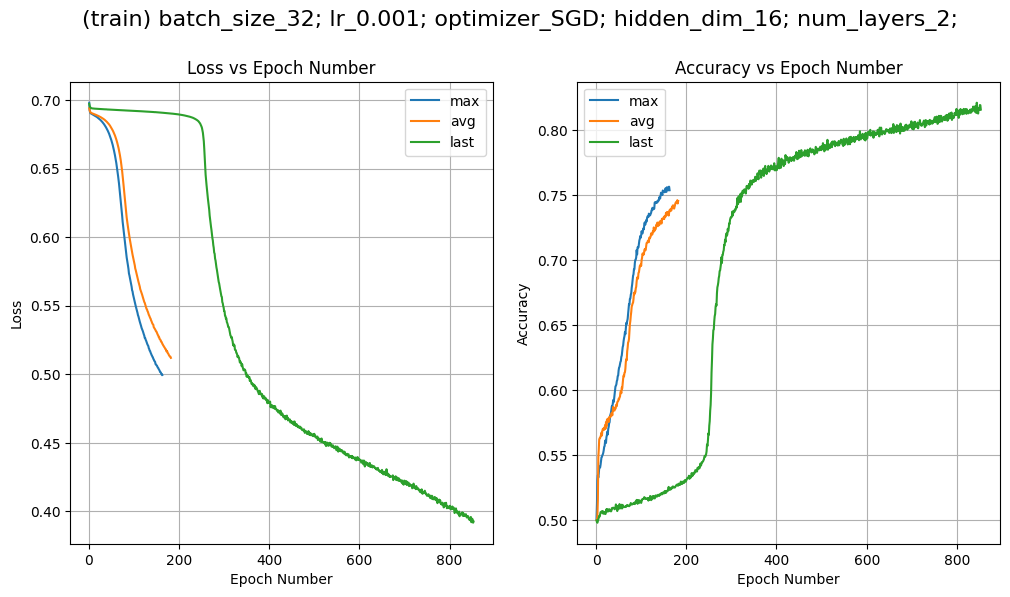

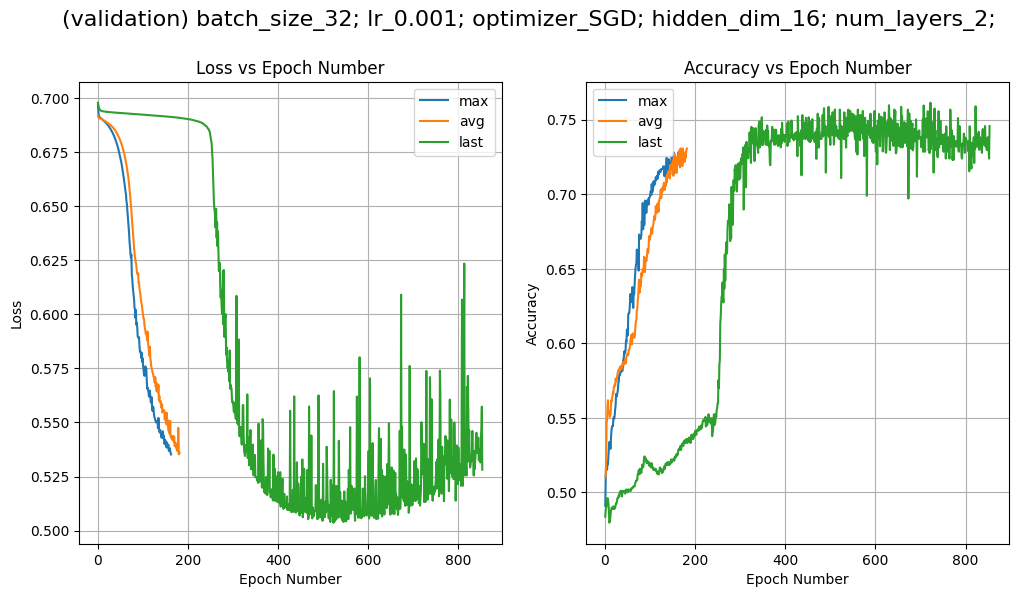

In [67]:
#from visualization import plot_multiple_loss_acc_graph

subtitle = f"batch_size_{batch_size}; lr_{learning_rate}; optimizer_{optimizer_name}; hidden_dim_{hidden_dim}; num_layers_{num_layers};\n"
save_filename_prefix = f"rnn/part_c_BEST/batch_size_{batch_size}-lr_{learning_rate}-optimizer_{optimizer_name}-hidden_dim_{hidden_dim}-num_layers_{num_layers}"
  
plot_multiple_loss_acc_graph(
    loss_list=part_c_model_df['train_loss_arr'],
    acc_list=part_c_model_df['train_acc_arr'],
    label_list=SEARCH_SPACE["sentence_representation_type"],
    dataset_type="train",
    subtitle=subtitle,
    save_filename_prefix=save_filename_prefix,
    display=True
)

plot_multiple_loss_acc_graph(
    loss_list=part_c_model_df['val_loss_arr'],
    acc_list=part_c_model_df['val_acc_arr'],
    label_list=SEARCH_SPACE["sentence_representation_type"],
    dataset_type="validation",
    subtitle=subtitle,
    save_filename_prefix=save_filename_prefix,
    display=True
)


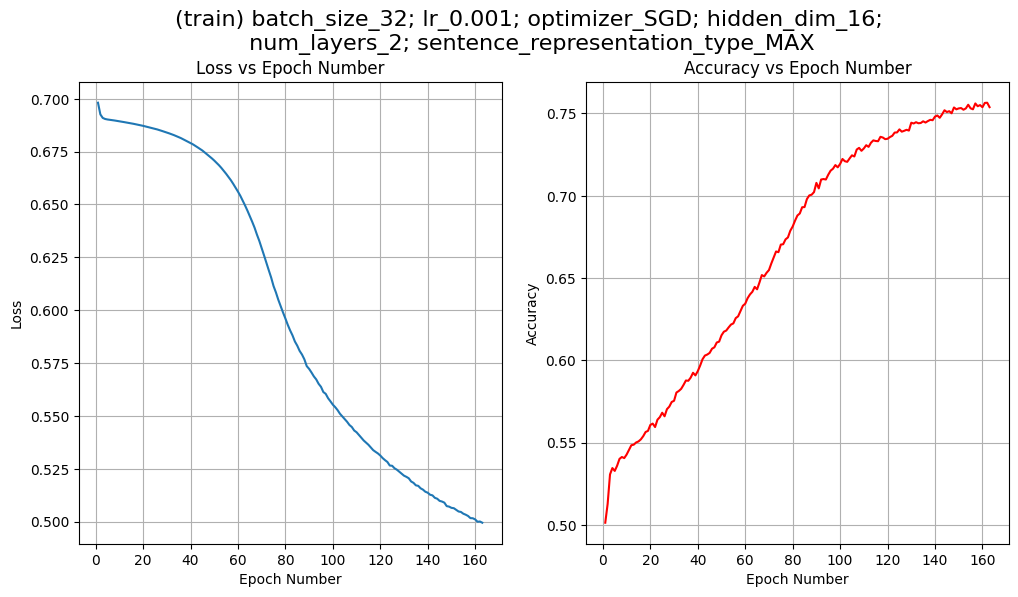

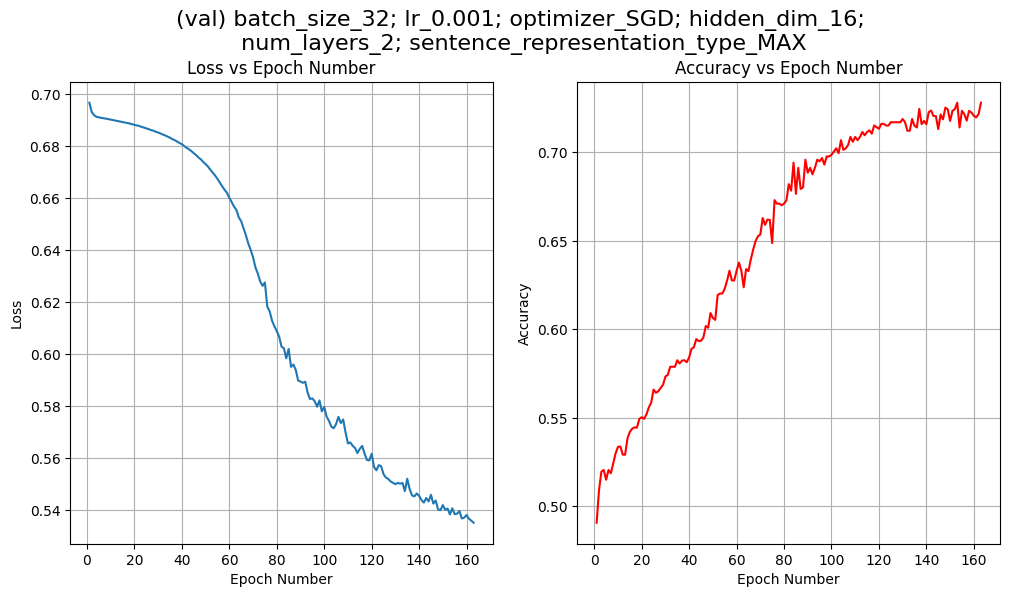

In [70]:
subtitle = f"batch_size_{batch_size}; lr_{learning_rate}; optimizer_{optimizer_name}; hidden_dim_{hidden_dim};\n num_layers_{num_layers}; sentence_representation_type_MAX"
save_filename_prefix = f"rnn/part_c_BEST/batch_size_{batch_size}-lr_{learning_rate}-optimizer_{optimizer_name}-hidden_dim_{hidden_dim}-num_layers_{num_layers}-sentence_representation_type_MAX"
  
plot_loss_acc_graph(
    loss_list=part_c_model_df['train_loss_arr'][0],
    acc_list=part_c_model_df['train_acc_arr'][0],
    dataset_type="train",
    subtitle=subtitle,
    save_filename_prefix=save_filename_prefix,
    display=True
)

plot_loss_acc_graph(
    loss_list=part_c_model_df['val_loss_arr'][0],
    acc_list=part_c_model_df['val_acc_arr'][0],
    dataset_type="val",
    subtitle=subtitle,
    save_filename_prefix=save_filename_prefix,
    display=True
)

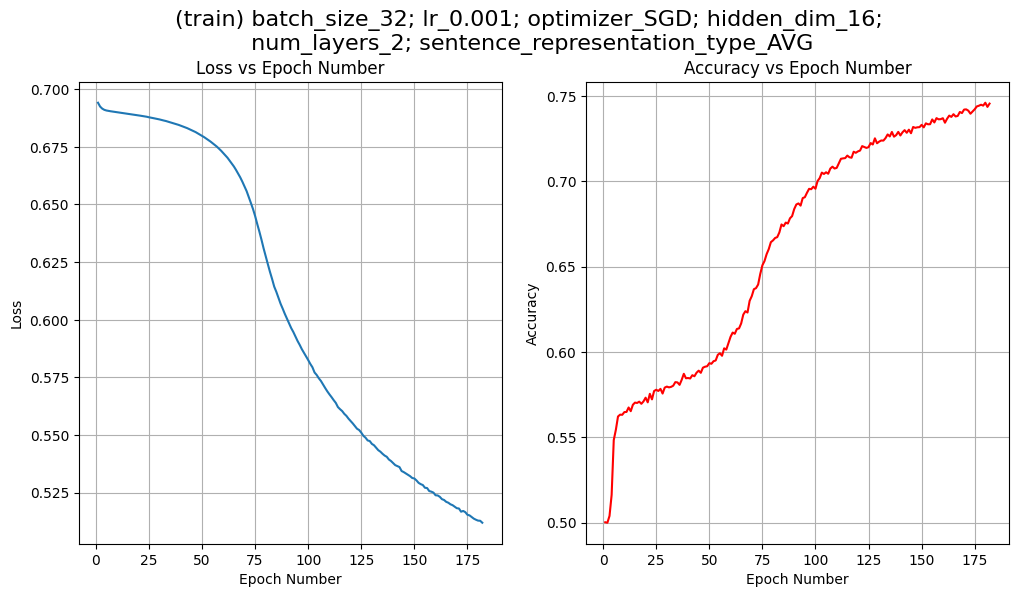

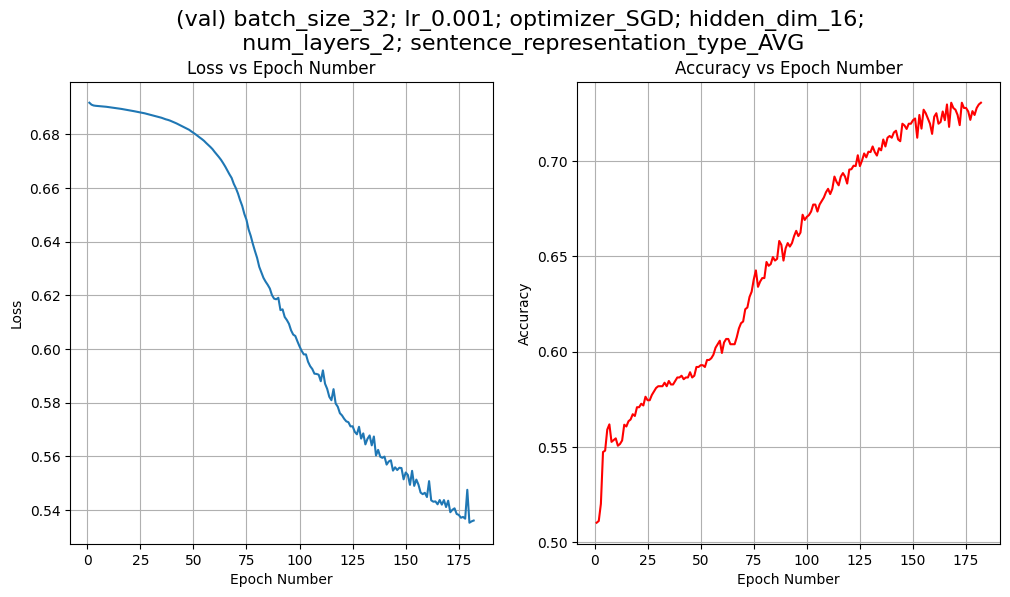

In [71]:
subtitle = f"batch_size_{batch_size}; lr_{learning_rate}; optimizer_{optimizer_name}; hidden_dim_{hidden_dim};\n num_layers_{num_layers}; sentence_representation_type_AVG"
save_filename_prefix = f"rnn/part_c_BEST/batch_size_{batch_size}-lr_{learning_rate}-optimizer_{optimizer_name}-hidden_dim_{hidden_dim}-num_layers_{num_layers}-sentence_representation_type_AVG"
  
plot_loss_acc_graph(
    loss_list=part_c_model_df['train_loss_arr'][1],
    acc_list=part_c_model_df['train_acc_arr'][1],
    dataset_type="train",
    subtitle=subtitle,
    save_filename_prefix=save_filename_prefix,
    display=True
)

plot_loss_acc_graph(
    loss_list=part_c_model_df['val_loss_arr'][1],
    acc_list=part_c_model_df['val_acc_arr'][1],
    dataset_type="val",
    subtitle=subtitle,
    save_filename_prefix=save_filename_prefix,
    display=True
)

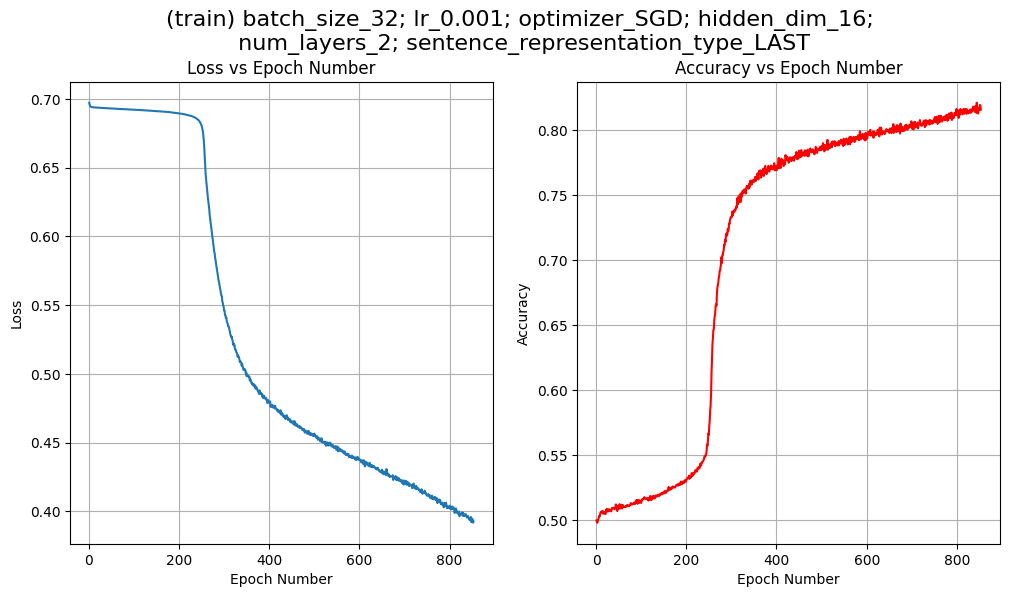

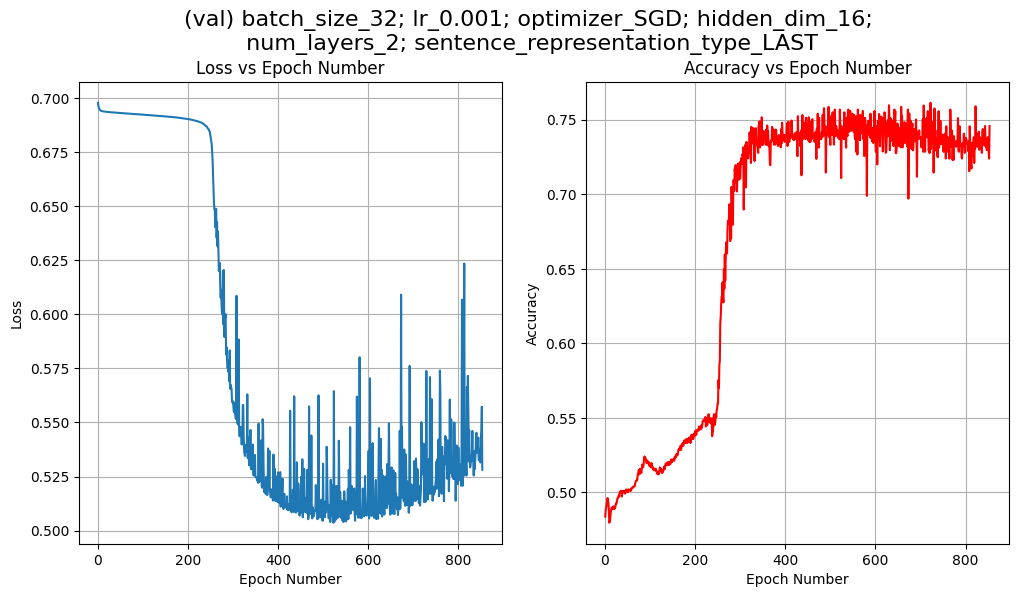

In [72]:
subtitle = f"batch_size_{batch_size}; lr_{learning_rate}; optimizer_{optimizer_name}; hidden_dim_{hidden_dim};\n num_layers_{num_layers}; sentence_representation_type_LAST"
save_filename_prefix = f"rnn/part_c_BEST/batch_size_{batch_size}-lr_{learning_rate}-optimizer_{optimizer_name}-hidden_dim_{hidden_dim}-num_layers_{num_layers}-sentence_representation_type_LAST"
  
plot_loss_acc_graph(
    loss_list=part_c_model_df['train_loss_arr'][2],
    acc_list=part_c_model_df['train_acc_arr'][2],
    dataset_type="train",
    subtitle=subtitle,
    save_filename_prefix=save_filename_prefix,
    display=True
)

plot_loss_acc_graph(
    loss_list=part_c_model_df['val_loss_arr'][2],
    acc_list=part_c_model_df['val_acc_arr'][2],
    dataset_type="val",
    subtitle=subtitle,
    save_filename_prefix=save_filename_prefix,
    display=True
)